# Deep Learning regression of biodiversity data

## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [ ]:
!git clone https://github.com/amarmeddahi/sounds-of-nature.git

Cloning into 'sounds-of-nature'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 131 (delta 45), reused 83 (delta 17), pack-reused 0
Receiving objects: 100% (131/131), 33.27 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
path_data = "./sounds-of-nature/data/latent_space_mel256_512.csv"

In [ ]:
data = pd.read_csv(path_data)
joint_table = pd.read_csv("./sounds-of-nature/data/reg-ind_joint_table.csv")
regression = pd.read_csv("./sounds-of-nature/data/regression.csv")

## Cleaning the dataset

In [ ]:
# Drop duplicate rows
data = data.drop_duplicates()

In [ ]:
# Drop columns with high percentage of missing values
missing_threshold = 0.8
data = data.dropna(thresh=int(missing_threshold * len(data)), axis=1)

In [ ]:
# Drop rows with missing values
data = data.dropna()

## Selecting the labels

In [ ]:
X = data.iloc[:, 3:-1].values.astype(float)

In [ ]:
y = []
for filename in data['filename']:
  id = joint_table.loc[joint_table['filename'] == filename, 'transect'].values[0]
  y.append(regression.loc[regression['id'] == id].values[0][1:])
y = np.array(y)

## Encoding the labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_idx = regression.columns.get_loc('TFV_G11_GROUP') - 1
y[:,cat_idx] = le.fit_transform(y[:,cat_idx])
y = y.astype(float)

In [ ]:
# Print the categorical values and their corresponding integer values
print('Categorical values:', le.classes_)
print('Integer values:', le.transform(le.classes_))

Categorical values: ['Conifères' 'Feuillus' 'Mixte']
Integer values: [0 1 2]


## Splitting the dataset into the Training set and Test set

In [ ]:
# Splitting randomy the dataset into the Training set and Test set (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Building the model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

numLabels = y_train.shape[1]

# Initialising the ANN
regressor = Sequential()

# Adding the input layer and the first hidden layer
regressor.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
regressor.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
regressor.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
regressor.add(Dense(units = numLabels, kernel_initializer = 'uniform', activation = 'linear'))

In [ ]:
regressor.build(input_shape=(None, X_train.shape[1]))
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 14)                910       
                                                                 
Total params: 173,390
Trainable params: 173,390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training the models

In [ ]:
# Checkpoint Callback
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
# Fitting the ANN to the Training set
history = regressor.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
89/93 [===========================>..] - ETA: 0s - loss: 113483.9219
Epoch 1: val_loss improved from inf to 10595.49805, saving model to weights.best.hdf5
93/93 [==============================] - 2s 8ms/step - loss: 109069.9922 - val_loss: 10595.4980
Epoch 2/100
89/93 [===========================>..] - ETA: 0s - loss: 6824.8345
Epoch 2: val_loss improved from 10595.49805 to 5321.15381, saving model to weights.best.hdf5
93/93 [==============================] - 0s 5ms/step - loss: 6708.1265 - val_loss: 5321.1538
Epoch 3/100
84/93 [==========================>...] - ETA: 0s - loss: 4251.8994
Epoch 3: val_loss improved from 5321.15381 to 4382.03125, saving model to weights.best.hdf5
93/93 [==============================] - 1s 6ms/step - loss: 4280.1611 - val_loss: 4382.0312
Epoch 4/100
85/93 [==========================>...] - ETA: 0s - loss: 3360.2085
Epoch 4: val_loss improved from 4382.03125 to 3602.60181, saving model to weights.best.hdf5
93/93 [==============================

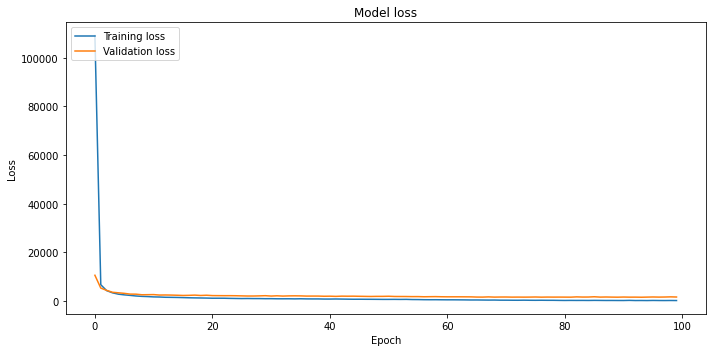

In [ ]:
# Plot training & validation accuracy and loss values in the same figure (1 row, 2 columns)
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
regressor.load_weights(filepath)

## Evaluating the model

In [ ]:
# Evaluate the model
score = regressor.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: 1570.237548828125
